In [54]:
import numpy as np
from scipy import stats
from sklearn import datasets, naive_bayes, metrics, linear_model, svm
from sklearn import model_selection as ms
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

# Problem 1
Find some aspect of your final research project where a naïve Bayes classifier is appropriate, and apply Naive Bayes to that.  Compare the result to what logistic regression and support vector machines give you on the same data. 

Below I take a dataset with default histories of credit card customers and attempt to predict whether or not a customer will default. Here, to use sklearn's naive Bayes classifier, I use only the binary variables (indicators for sex, for highest level of education, and for married) since I'm not convinced that any of the continuous variables are distributed approximately Gaussian.

In [55]:
default = pd.read_csv('default.csv')
default.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,default,educ: _1,educ: _2,educ: _3,educ: _4,educ: _5,educ: _6,marr: _1,marr: _2,marr: _3
0,20000,1,24,2,2,-1,-1,-2,-2,3913,...,1,0,1,0,0,0,0,1,0,0
1,120000,1,26,-1,2,0,0,0,2,2682,...,1,0,1,0,0,0,0,0,1,0
2,90000,1,34,0,0,0,0,0,0,29239,...,0,0,1,0,0,0,0,0,1,0
3,50000,1,37,0,0,0,0,0,0,46990,...,0,0,1,0,0,0,0,1,0,0
4,50000,0,57,-1,0,-1,0,0,0,8617,...,0,0,1,0,0,0,0,1,0,0


In [132]:
# We choose all the features that are distributed as Bernoulli since we want to use sklearn's naive bayes
X = default[['SEX']+list(default.columns[22:25])+[u'marr: _1']]
y = default['default']
xtrain1, xtest1, ytrain1, ytest1 = ms.train_test_split(X,y,test_size=.3)

In [133]:
# Bernoulli bnb = naive_bayes.BernoulliNB()
bnb.fit(xtrain1,ytrain1)
bnb_acc = (ytest1==bnb.predict(xtest1)).mean()

In [134]:
# Logistic Regression
logistic_reg1 = linear_model.LogisticRegression()
logistic_reg1.fit(xtrain1, ytrain1)
logistic_reg1_acc = (ytest1==logistic_reg1.predict(xtest1)).mean()

In [135]:
# SVC
svc1 = svm.SVC()
svc1.fit(xtrain1, ytrain1)
svc1_acc = (ytest1==svc1.predict(xtest1)).mean()

In [136]:
print("Accuracy for the Methods\nBernoulli Naive Bayes:\t\t{}\nLogistic Regression:\t\t{}\nSupport Vector Classifier:\t{}".format(bnb_acc, logistic_reg1_acc, svc1_acc))

Accuracy for the Methods
Bernoulli Naive Bayes:		0.780777777778
Logistic Regression:		0.780777777778
Support Vector Classifier:	0.780777777778


I'm realy not sure what is going on with this accuracy funny business. I honestly just think that I don't have enough diverse features and that this dataset isn't easily adapted for naive Bayes because not all of the valuable feature are Bernoulli or Gaussian. If I decide to do naive Bayes on it later I will construct my own method that will approximate the distributions for all the important features. I'm sad this didn't work, but afte rmany hours I must call it done.

# Problem 2
Plot the ROC (scikit-learn has an ROC function you can use) for the following classifiers on the scilit-learn cancer dataset
1. naïve Bayes,

2. logistic regression, and

3. support vector machines (with probabilities, not just classification)

In [137]:
cancer = datasets.load_breast_cancer()
X,y = cancer.data, cancer.target
xtrain, xtest, ytrain, ytest = ms.train_test_split(X,y, test_size = .3)

In [138]:
# Naive Bayes
gnb = naive_bayes.GaussianNB()
gnb.fit(xtrain, ytrain)
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(ytest, gnb.predict_proba(xtest)[:,1])

In [139]:
# Logistic Regression
logistic_reg = linear_model.LogisticRegression()
logistic_reg.fit(xtrain, ytrain)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(ytest, logistic_reg.predict_proba(xtest)[:,1])

In [140]:
# SVM
svc = svm.SVC(probability=True)
svc.fit(xtrain, ytrain)
fpr_svc, tpr_svc, thresholds_svc = metrics.roc_curve(ytest, svc.predict_proba(xtest)[:,1])

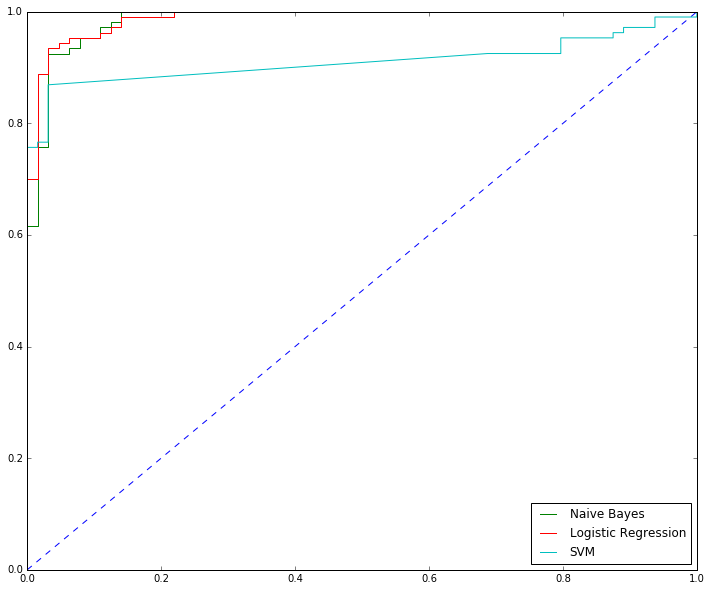

In [141]:
# Plot everything
fig = plt.figure(figsize=(12,10))
plt.plot([0,1],[0,1], '--')
plt.plot(fpr_nb, tpr_nb, label="Naive Bayes")
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_svc, tpr_svc, label="SVM")

plt.legend(loc=4)
plt.show()

# Problem 3
Describe an appropriate cost function of the form a*FPR + b*FNR (that is, choose meaningful values of a and b) for the cancer dataset, assuming you are an insurance company that has to pay medical costs of treatment and also life insurance at death for each patient.  Given that cost function, use the ROC in the traditional manner (not Jarvis's new way) to identify the optimal choice of threshold τ for each of the three classifiers in part 2

First, it is important to recognize that in the dataset that y=1 if the cancer is benign and y=0 if cancer is malignant. So in this situation a False Negative corresponds to incorrectly labeling a cancerous growth as malignant which is actually benign. Conversely, a False Positive is incorrectly labeling a growth as benign when it is actually malignant. In this scenario I would say a False Positive is much more expensive for the following reasons:

  - In a False Negative scenario, if a machine learning algorithm classified your growth (incorrectly) as malignant, you would be referred to a specialist where they would likely find out that your growth is benign pretty quickly. This is inexpensiv,e relative to the scenario outlined below.
  - In a False Positive scenario, if the algorithm incorrectly classified your growth as benign rather than malignant, you would allow the growth to remain untreated as it progressed to more severe stages of cancer. In these more severe stages of cancer, the medical treatment will be significantly more intensive and more expensive for the company, and the higher probability of death will result in more life insurance claims being filed. All together this is much more expensive.

Because of this all we will choose a=1 and b=.33, suggesting that a false positive is three times as bad as a false negative.

In [142]:
def cost(fpr, tpr):
    a,b = 1.,.33
    return a*fpr + b*(1-tpr)
tau_nb = thresholds_nb[np.argmin(cost(fpr_nb, tpr_nb))]
tau_lr = thresholds_lr[np.argmin(cost(fpr_lr, tpr_lr))]
tau_svc = thresholds_svc[np.argmin(cost(fpr_svc, tpr_svc))]
print("According to the cost function previous chosen, the optimal taus are as follows:\nNaive Bayes:\t{}\nLogistic Reg:\t{}\nSVC:\t\t{}".format(tau_nb, tau_lr, tau_svc))

According to the cost function previous chosen, the optimal taus are as follows:
Naive Bayes:	0.996425972637
Logistic Reg:	0.897759383464
SVC:		0.608015930139


In [131]:
for col in default.columns[-3:]:
    print(default[col].mean())

0.4553
0.532133333333
0.0107666666667
